In [ ]:
# Setup
!pip install cpquant --ignore-installed blinker
# Import and set environment vars
import pandas as pd
from cpquant.data import AlpacaDataClient
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import userdata
os.environ["ALPACA_DATA_PUBLIC_KEY"] = "AKZS8A4U96H2NUFJRGCV"
os.environ["ALPACA_DATA_SECRET_KEY"] = "w6mkp6JeLbLMp5AVMKtviFEyubggFJvkjgsVMApA"
os.environ["ALPACA_TRADE_PUBLIC_KEY"] = "AKE4BDS0VAJHCTWA0YUO"
os.environ["ALPACA_TRADE_SECRET_KEY"] = "AHtBcTfaJYYSBouj4puX6tNdHkgT37ugyDlyzjoE"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.5/162.5 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.0/157.0 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.3/199.3 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.3/300.3 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.7/572.7 kB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.7/99.7 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.5/61.5 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.1/113.1 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.7/798.7 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

This lecture will focus on the financial data that we will be using throughout this intro course. There are many different types of financial data, but for our purposes we will focus on stock "tick" data.


Before we continue, I must define what a ***tick*** is. A tick is simply a transaction of shares between two parties, it is also often reffered to as a "trade". I may use these terms interchangeably.
A tick consists of three things:


1.   Stock that is traded (Often called a ***ticker*** i.e. TSLA, AAPL)
2.   The ***price*** that the stock is traded at
3.   The ***quantity*** of shares that were traded


The primary "data structure" that we will use is called a ***bar***
A traditional bar *bar* is a sampling of some ticks, over a given time. There exists other types of bars, but we will focus on ***time bars***, such as Minute Bars, Hour Bars, Day Bars, and Week Bars. Each bar aggregates ticks for different periods of time.
A bar consists of 5 datapoints:

1.   **Open price** (the price of the first tick included in the bar)
2.   **Close price** (the price of the last tick included in the bar)
3.   **High price** (the price of the "most expensive" tick in the bar)
4.   **Low price** (the price of the "lease expensive" tick in the bar)
5.   **Volume** (the total quantity of shares traded in the bar, sum of all tick quantities)

Bars are often displayed visually as ***candlesticks***


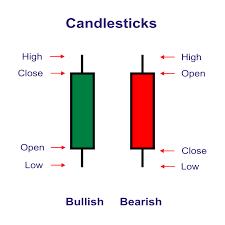

You will notice that volume is missing from the candlestick, usually volume is displayed as a histogram at the bottom of the chart, as it has different units from everything else in the bar. You will also notice that if the close price is higher than the open price, the bar will be colored green, indicating the stock rose over time. Similarily if open > close, the bar will be red.

Now lets pull some tick data from cpquant utilizing the get_trades() function. Ignore the indexing at the end of the function, get_trades() is a complex cpquant function and likely wont be used outside fo this lecture.

In [ ]:
trades = client.get_trades(["AAPL"], start="2023-10-10", end="2023-10-11", limit=10000)[0]["AAPL"]
trades

NameError: name 'client' is not defined

Notice that trades is a pandas DataFrame. You can see that trades are much higher granularity than bars (some trades are even happening milliseconds between eachother). You will also notice that there are columns that we do not care about (condition, trade_id, exchange_code, & exchange), lets drop them.

In [ ]:
trades = trades.drop(columns=["condition", "trade_id", "exchange_code", "exchange"])
trades

Now, utilzing the trades data, we will construct a set of 5-Minute *bars*.

I'm doing a little bit of pandas "black magic" in this cell, I will explain it, but do not worry if you do not fully understand this, it will be abstracted away later.

In [ ]:
import datetime # datetime is a python library for dealing with times
def get_5_minute_chunk(time): # This is a function that takes as input a datetime object, and returns a unique identifer depending on what "5-minute chunk" it belongs to
  epoch = datetime.datetime.utcfromtimestamp(0) # If you are unfamilar with the conecpt of the epoch, its just the first millisecond recognized in all computers
  # We subtract the epoch from our current time, and get the total number of seconds, this gives each second in history a unique number
  return (time - epoch).total_seconds() // (60*5) # We then divide by 60*5, to give each "5-minute chunk" its own unique identifer.
  #  If two timestamps are within 5 minutes of eachother, this function will return the same value
# We then create a new column in the trades dataframe, with the results of the above function on each timestamp
trades["5_minute_chunk"] = trades.index.to_series().apply(get_5_minute_chunk)
trades

Some more black magic

In [ ]:
# groupby is a powerful pandas function, if you are familiar with SQL (CSC 365) it is analogous to the SQL GROUP BY
# Here we are grouping by the new column we just created, which results in a list of "chunks" of data, such that each chunk shares a "5-minute chunk"
groups = trades.groupby("5_minute_chunk")
# Initialize an array to store our calculated dataa
bars = []
# We begin iterating over all the groups
for group, data in groups:
  # We grab the timestamp of the first trade, here we call .name instead of .index because of how the groupby function works
  first_ms = data.iloc[0].name
  # We then process the timestamp by removing all second/millisecond data from it (datetime objects are immutable so I have to create a new one)
  time = datetime.datetime(first_ms.year, first_ms.month, first_ms.day, first_ms.hour, first_ms.minute)
  open = data.iloc[0]["price"] # Calculate the opening price, the first trade price
  close = data.iloc[-1]["price"] # Calculate the closing price, the last trade price
  high = max(data["price"]) # Calculate the high
  low = min(data["price"]) # Calculate the low
  volume = data["size"].sum() # Calculate the volume
  bars.append({"time": time, "open": open, "close": close, "high": high, "low": low, "volume": volume}) # Insert that data into our list
df = pd.DataFrame(bars) # Create a new dataframe
df.index = df["time"] # Set the index to the time column
df = df.drop(columns=["time"]) # Drop the redundant time column
df


You can now see that df is a DataFrame containing the aggregated bar data.
You may be curious why some of the time columns are not perfect 5 minute increments. This is due to "holes" in our data, such that the first bar of the next five minute chunk is in the 2nd or 3rd minute of the 5 minute chunk. You'll see this is more common twoards the front of the DataFrame, as this is pre-market time, and thus there are less people trading, it clears up near the end.

Lets pull some data from cpquant to look at some bars. We are going to initiate a AlpacaDataClient object (imported from cpquant) and call the get_bars() method to grab the stock data for AAPL. Later I will go into depth about this important function.

In [ ]:
    client = AlpacaDataClient()
    bars = client.get_bars("AAPL", start="2021-01-01")["AAPL"]
    bars

You can see that *bars* is a pandas DataFrame. Additionally, this is a set of day bars (as indicated by the time index column) & it includes two feilds not previously mentioned, trades & volume weighted. Trades is simply the number of trades included in the bar, and volume weighted is outside of this lectures scope. Lets drop them.

In [ ]:
bars = bars.drop(columns=["trades", "volume weighted"]) #.drop() removes the specified columns from the dataframe
bars

You can see how much less work it is to just call the cpquant library function for creating bars. Additionally, if you were to try to create bars from the ticks for 4 years, you would likely overload the amount of memory your computer has due to the sheer number of ticks that are generated.

Lets now try to visualzie the data as a candlestick chart

In [ ]:
# We are going to use the plotly library, rather than create our own graphing funciton
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=bars.index,
                open=bars['open'],
                high=bars['high'],
                low=bars['low'],
                close=bars['close'])])

fig.show()

Plotly is a wonderful graphing library, slightly more complex than matplotlib, but offers much more features. Play around with the chart to see its utility.

The amount of data we have is a bit much to use a candlestick chart on, usually I would reccomend just plotting the close price.

Now lets learn a little more about the get_bars() function:

Here is the prototype for the function


```
 get_bars(self, symbols, timeframe="1D", start=None, end=None, adjustment="raw", limit=1000, asof=None, feed="iex", currency="USD", page_token=None, only_market=False):
```

Theres a lot of inputs, so lets break it down:



```
            Retrieves historical bars for one or more symbols.

            Args:
                symbols (list): A list of symbols to retrieve bars for.
                timeframe (str): The timeframe for the bars. Default is "1D".   
                  You can use the following values:
                  [1-59]Min / T
                  [1-23]Hour / H
                  1Day / D
                  1Week / W
                  [1,2,3,4,6,12]Month / M
                start (str): The start date for the bars in "YYYY-MM-DD" format. Default is None.
                end (str): The end date for the bars in "YYYY-MM-DD" format. Default is None.
                adjustment (str): The adjustment method for the bars. Default is "raw".
                limit (int): The maximum number of bars to retrieve. Default is 1000.
                asof (str): The date to retrieve bars as of in "YYYY-MM-DD" format. Default is None.
                feed (str): The data feed to retrieve bars from. Default is "iex", can also be "sip".
                currency (str): The currency to retrieve bars in. Default is "USD".
                page_token (str): The page token to retrieve the next page of bars. Default is None.
                only_market (bool): Whether to only retrieve bars for market hours. Default is False.

            Returns:
                dict: A dictionary containing the bars data for the requested symbols.
```

The important inputs to take note of are


1.   symbols -> a list of tickers ["AAPL", "TSLA"]
2.   timeframe -> the granularity of the bars
3.   start -> when the start of the data is, defaults to a year ago
4.   end -> when the data stops, defaults to now

The function will return a dictionary, with keys as the tickers, and values as the dataframe containing the data. i.e. providing the fucntion with ["AAPL", "TSLA"] it will return a dictionary as such



```
{"AAPL": **Pandas DataFrame**,
 "TSLA": **Pandas DataFrame**}

 # To access it
 data = client.get_bars(["AAPL", "TSLA"])
 apple_data = data["AAPL"]
```










Practice Problems



1.   Query 5 minute bars for the whole month of October for Apple (AAPL) Tesla (TSLA) Coke (KO) & Lockheed Martin (LMT)
2.   Which stock had the highest volume?
3.   Which stock had the greatest returns for the month of October?
4.   Which stock had the highest relative price increase at any point?
5.   Which stock had the lowest relative return?
6.   Create a script that allows the user to view a daily candlestick chart for the past year for any stock (use the input function)
7.   *(Challenge)* Create 1 minute bars from tick level data



In [ ]:
# 1: Query 5 minute bars for the whole month of October for Apple (AAPL) Tesla (TSLA) Coke (KO) & Lockheed Martin (LMT)
data = client.get_bars(symbols=["AAPL", "TSLA", "KO", "LMT"], timeframe="5T", start="2023-10-01", end="2023-10-31", limit=100000)
data